In [1]:
import keras.backend as K
from keras.datasets import mnist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn.neighbors as skn

2023-02-04 15:44:04.997491: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-04 15:44:05.333115: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-04 15:44:05.333175: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-04 15:44:08.594427: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [ ]:
# CRONOMETRARE

# CONTROLLARE

# OTTIMIZZARE (SPECIALMENTE GLI ULTIMI DUE ASSIGNMENT CON PRECOMPUTING)

# NELLE FUNZIONI DEFINITE CAPIRE BENE QUALI SONO I PARAMETRI DI INPUT CHE SI ASPETTANO DI AVERE
# (SOPRATTUTTO CAPIRE SE BISOGNA PASSARE ANCHE I DATASET)

### importing the dataset

In [2]:
# splitting data in train and set
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
# input images dimensions
img_rows, img_cols = 28, 28

# preparing images
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols)
    input_shape = (img_rows, img_cols)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

np.savez_compressed('mnist.npz', x_train, y_train, x_test, y_test)

In [4]:
arc = np.load('mnist.npz')

x_train = arc['arr_0']
y_train = arc['arr_1']
x_test  = arc['arr_2']
y_test  = arc['arr_3']

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


we try to print one of the images (the number 15)

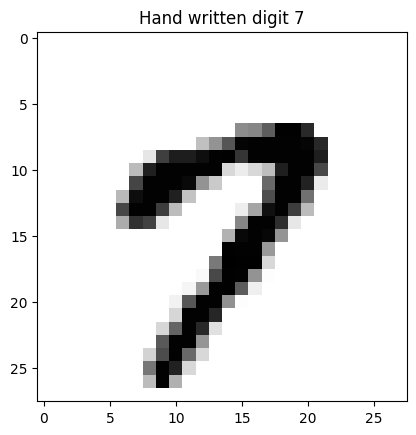

In [8]:
N=15

plt.imshow(x_train[N], cmap='gray_r')
_ = plt.title('Hand written digit '+str(y_train[N]))

### Assignment one
Defining different distances

In [5]:
def dist_infty(a, b):
    return np.max(np.fabs(a - b))

def dist_1(a, b):
    return np.sum(np.fabs(a - b))

def dist_2(a, b):
    return math.sqrt(np.sum(np.fabs(a - b)**2))   # VALUTARE SE TOGLIERE IL VALORE ASSOLUTO (PUÒ DARSI CHE NON SIA LA STESSA COSA PER IL COMPUTER)

In [38]:
# TOGLIERE DA VERSIONE FINALE

# just to check that the functions work
dist_infty(x_train[0], x_train[0]), dist_1(x_train[5], x_train[5]), dist_2(x_train[5], x_train[5])

(0.0, 0.0, 0.0)

### Assignment two
Computing distance among first N elements of the train dataset

In [6]:
# VALUTARE SE TOGLIERE CALCOLO DISTANZA CON SE STESSO

def dist_mat(N, dist):

    # initializing matrix of distances
    D = np.empty((N, N))
    for i in range(N):
        # computing distances
        D[i, i:N] = np.array([dist(x_train[i], x_train[j]) for j in range(i, N)])
        # copying the already computed ones
        D[i+1:N, i] = D[i, i+1:N]
    return D

In [26]:
# displaying some results (saved in CSV file)
N_first = 100
np.savetxt("dist_max.csv", dist_mat(N_first, dist_1), delimiter=",")

In [7]:
# checking that the function works for all the distances (for the first 300 images)
test = False
for dist in [dist_infty, dist_1, dist_2]:
    D_test = dist_mat(300, dist)
    for i in range(300):
        for j in range(300):
            if D_test[i, j] - dist(x_train[i], x_train[j]) > 1e-10:
                test = True

print(test)

False


### Assignment three
Computing and plotting the distance matrices (for the first 100 images); the darker the 'pixel' the higher the distance

In [8]:
Dinfty = dist_mat(100, dist_infty)
D1 = dist_mat(100, dist_1)
D2 = dist_mat(100, dist_2)

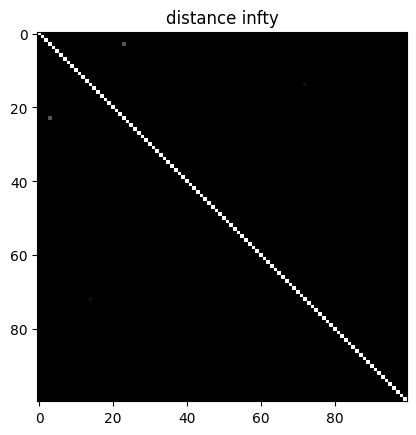

In [44]:
plt.imshow(Dinfty, cmap='gray_r')
_ = plt.title('distance infty')

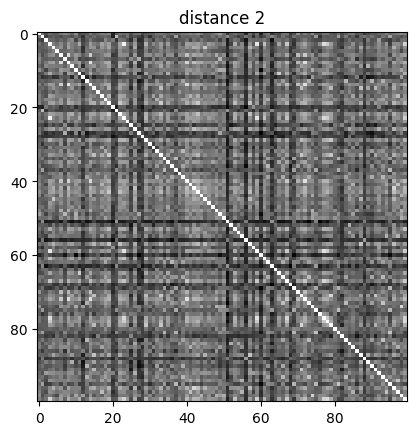

In [45]:
plt.imshow(D1, cmap='gray_r')
_ = plt.title('distance 2')

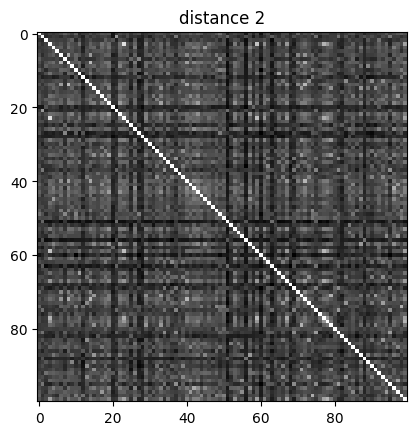

In [46]:
plt.imshow(D2, cmap='gray_r')
_ = plt.title('distance 2')

### Assignment four
Applying and testing the algorithm

In [33]:
# CAPIRE SE NELLA CONSEGNA CONFONDE L'EFFICIENCY CON L'EFFECTIVNESS

def comp_error(D):

    error_counter = 0
    dim = D.shape[0]
    for i in range(dim):
        # finding the index (j) of the nearest image to the i-th one
        j = np.argmin(np.concatenate((D[i, :i], D[i, i+1:])))
        if y_train[i] != y_train[j]:
            error_counter += 1
    
    return error_counter/D.shape[0]

In [10]:
print(comp_error(Dinfty))
print(comp_error(D1))
print(comp_error(D2))

0.72
0.61
0.62


### Assignment five
Computing the error for different N's using different distances

In [60]:
N_test = (100,200,400,800,1600)

error = np.empty((len(N_test), 3))   # every row a different N and every column a different distance

for i in range(len(N_test)):
    error[i, 0] = comp_error(dist_mat(N_test[i], dist_infty))
for i in range(len(N_test)):
    error[i, 1] = comp_error(dist_mat(N_test[i], dist_1))
for i in range(len(N_test)):
    error[i, 2] = comp_error(dist_mat(N_test[i], dist_2))

In [61]:
# LA 'TENDENZA' È GIUSTA MA I VALORI SONO ABBASTANZA DIVERSI DA QUELLI DEI PROF

display(error)

array([[0.72    , 0.61    , 0.62    ],
       [0.67    , 0.565   , 0.565   ],
       [0.61    , 0.5725  , 0.57    ],
       [0.595   , 0.53    , 0.53125 ],
       [0.579375, 0.495   , 0.49125 ]])

### Assignment six
Exploiting the neighboring information of the pixels

In [ ]:
# CAPIRE BENE COSA SI INTENDE CON 'PRECOMPUTING EVERYTHING YOU CAN IN ADVANCE'

# CAPIRE COME È FATTA LA FUNZIONE CHE DESCRIVE L'IMMAGINE: COME FA AD ESSERE CONTINUA E COME
# SI FA A CALCOLARE GRADIENTE E INTEGRALE SE IL DOMINIO È DISCRETO? CHE SI DEBBA FARE
# UN'INTERPOLAZIONE? OPPURE BISOGNA USARE UN GRADIENTE E UN INTEGRALE APPOSITI PER DOMINI
# DISCRETI?

# NELLA DEFINZIONE DELLA DISTANZA ANCHE IL TERMINE (a-b)^2 È SOTTO L'INTEGRALE (CONTROLLARE)

### Assignment seven
Using BallTree algorithm

In [ ]:
# CAPIRE SE È POSSIBILE USARE DENTRO BALLTREE LE DISTANZE PRECALCOLATE
# (IN OGNI CASO BISOGNA PASSARE LA FUNZIONE DELLA DISTANZA, PERCHÈ SERVE PER CALCOLARE
# LA DISTANZA DAI CENTRI DELLE BALL)

# AGGIUNGERE DISTANZA DELL'ASSIGNMENT 5

In [9]:
# we need to reshape the images data to be able to use the BallTree
height = x_train.shape[0]
width = 28**2
x_train_reshaped = x_train.reshape((height, width))

In [10]:
# again we have to reshape the images data
x_test_reshaped = x_test.reshape((x_test.shape[0], new_dim))

In [12]:
# UN PO' DIVERSO DA COME ERA VOLUTO ESATTAMENTE DAI PROF (OVVERO USANDO UN FOR LOOP)
# SCRIVERE ANCHE L'ALTRO E COMPARARE PERFORMANCE

def comp_error_bt(tree):

    error_counter = 0
    dim = x_test_reshaped.shape[0]   # VALUTARE SE CALCOLARE ALL'ESTERNO DELLA FUNZIONE E POI PASSARE COME PARAMETRO
    # querying the tree
    response_index = tree.query(x_test_reshaped, return_distance=False)
    response = y_train[response_index]
    # counting wrong predi
    for i in range(len(response)):   # LEVARE STO LOOP
        if (response[i] != y_test[i]):
            error_counter+=1
    
    return error_counter/dim

In [16]:
N_test_bt = (100, 200, 300)   # METTERE I VALORI RICHIESTI (QUESTI SONO SOLO PER TEST)
error_bt = np.empty((len(N_test_bt), 3))   # every row a different N and every column a different distance

for i in range(len(N_test_bt)):
    tree = skn.BallTree(x_train_reshaped[:N_test_bt[i], :], metric=dist_infty)
    error_bt[i, 0] = comp_error_bt(tree)
for i in range(len(N_test_bt)):
    tree = skn.BallTree(x_train_reshaped[:N_test_bt[i], :], metric=dist_1)
    error_bt[i, 1] = comp_error_bt(tree)
for i in range(len(N_test_bt)):
    tree = skn.BallTree(x_train_reshaped[:N_test_bt[i], :], metric=dist_2)
    error_bt[i, 2] = comp_error_bt(tree)

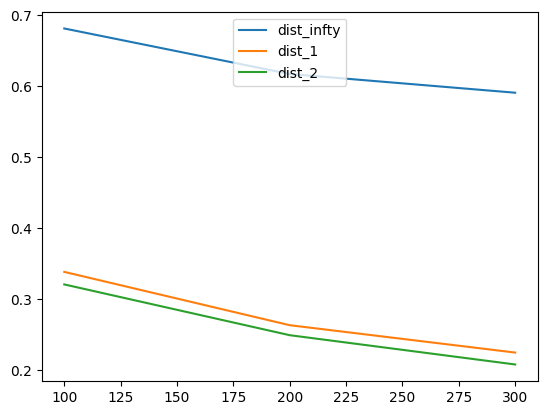

In [17]:
# AGGIUNGERE ROBA (TIPO TITOLO, ...)

# plot of the error for the three distances as function of N
plt.plot(N_test_bt, error_bt[:, 0], label='dist_infty')
plt.plot(N_test_bt, error_bt[:, 1], label='dist_1')
plt.plot(N_test_bt, error_bt[:, 2], label='dist_2')
leg = plt.legend(loc='upper center')
plt.show()

In [95]:
tree1 = skn.BallTree(x_train_reshaped[:100, :], metric=dist_1)
tree2 = skn.BallTree(x_train_reshaped[:10000, :], metric=dist_1)
print(comp_error_bt(tree1))
print(comp_error_bt(tree2))

0.3383
0.3383
